# Plotting Query Results

## Setup

In [1]:
# import Dependencies
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

In [2]:
# Import SQLAlchemy `automap` and other dependencies here
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import Session
from sqlalchemy.sql import label

In [3]:
# Create an engine for the `hawaii.sqlite` database
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

## Explore Database

In [4]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['Measurement', 'Station']

In [5]:
# Use `engine.execute` to select and display the first 10 rows from the Measurement table
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-07', 0.06, 70)]

In [6]:
# Use `engine.execute` to select and display the first 10 rows from the Station table
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

## Reflect Database and Query

In [7]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.Measurement
Station = Base.classes.Station

In [8]:
# Start a session to query the database
session = Session(engine)

In [9]:
# Plan Vacation range by choosing the start and end days
total_vacation_days = session.query(Measurement.date).\
                        filter(Measurement.date >="2010-01-01").\
                        filter(Measurement.date <="2010-01-10").\
                        order_by(Measurement.date.asc()).distinct().count()

In [10]:
print("Number of Vacation days: {}".format(total_vacation_days))

Number of Vacation days: 10


## Precipitation Analysis

In [11]:
# Query to get the latest date
current_time = datetime.now()
past_year = current_time - timedelta(days=365)
end_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
end_date

('2017-08-23')

In [12]:
# Query to retrieve the last 12 months of precipitation data.
precipitation_data = session.query(Measurement.date,Measurement.prcp).\
                    filter(Measurement.date >= "2016-08-23").\
                    order_by(Measurement.date.asc()).all()

In [13]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
df = pd.DataFrame(precipitation_data, columns = ["date","prcp"])
df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,0.02
4,2016-08-23,1.79


In [14]:
# Set the index to the date column.
precipitation_df=df.set_index('date')
precipitation_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


## Plot using Matplotlib

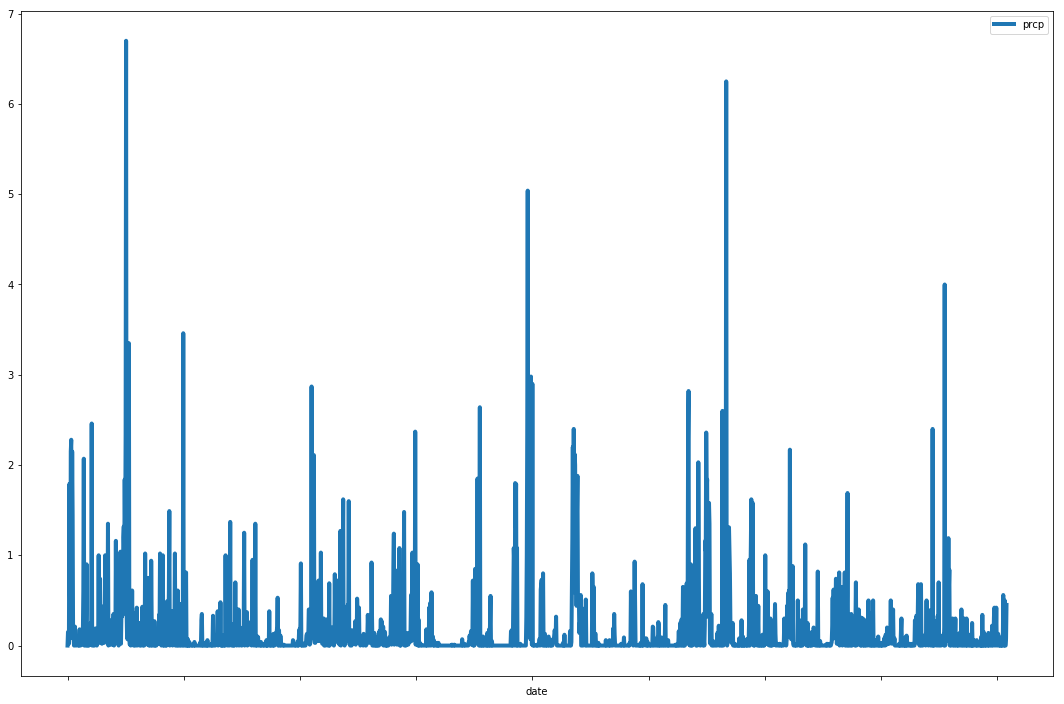

In [15]:

precipitation_df.plot(kind="line",linewidth=4,figsize=(15,10))
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

## Station Analysis

In [16]:
# Query to calculate the total number of stations
total_stations = session.query(Station).distinct().count()
print("Total number of Stations: {}".format(total_stations))

Total number of Stations: 9


In [17]:
# Query to find the most active stations
allstations=session.query(Station.name,Station.station, func.count(Measurement.id)).\
                           filter(Measurement.station == Station.station).\
                            group_by(Station.name,Station.station).\
                            order_by(func.count(Measurement.id).desc()).all()
allstations

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2696),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2685),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2572),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2484),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 1937),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1932),
 ('PEARL CITY, HI US', 'USC00517948', 683),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 342)]

In [18]:
# Station with the highest number of observations
allstations[0]

('WAIHEE 837.5, HI US', 'USC00519281', 2772)

In [19]:
# convert to dataframe
station_df = pd.DataFrame(allstations, columns=['Station_name','Station', 'Count'])
station_df

,Station_name,Station,Count
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"KANEOHE 838.1, HI US",USC00513117,2696
2,"WAIKIKI 717.2, HI US",USC00519397,2685
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2572
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2484
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,1937
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1932
7,"PEARL CITY, HI US",USC00517948,683
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,342


In [20]:
# Query to retrieve the last 12 months of temperature observation data (tobs)
station_temp=session.query(Measurement.tobs).\
                    filter(Measurement.date > '2016-08-23').all()

In [21]:
# Query to retrieve the last 12 months of temperature observation data (tobs)
# Filter by the station with the highest number of observations.
station_spec=session.query(Measurement.tobs).\
                    filter( (Measurement.station == 'USC00519281') & (Measurement.date > '2016-08-23') ).all()

In [22]:
plot_df=[i[0] for i in station_spec]

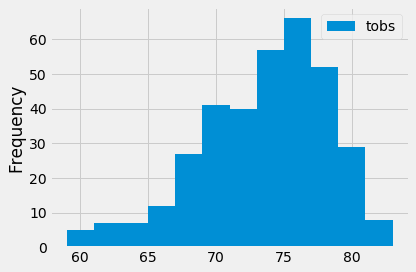

In [23]:
# Plot the results as a histogram with bins=12.
ax_1=pd.Series(plot_df).plot(kind='hist', bins=12)
ax_1.legend(["tobs"])
plt.tight_layout()
plt.show()

## Temperature Analysis

In [36]:

def calc_temps (date_st, date_end):
    temp_date= session.query(func.avg(Measurement.tobs),func.min(Measurement.tobs), func.max(Measurement.tobs)).\
                    filter( (Measurement.date >= date_st) & (Measurement.date <= date_end)).all()[0]
    return(temp_date)

In [37]:
temp_date=calc_temps('2017-01-01', '2017-01-10')

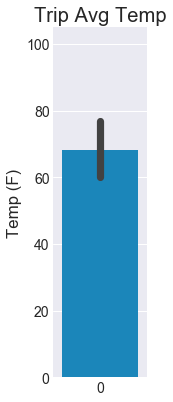

In [39]:
import seaborn as sns
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(1.5,6))
plt.ylabel("Temp (F)")
plt.ylim(0,105)
plt.title("Trip Avg Temp")
sns.barplot(ax=ax, data=temp_date)
plt.show()

In [27]:
def calc_temps ():
    start_date = input("Enter start date in the format %Y-%m-%d: ")
    end_date = input("Enter end date in the format %Y-%m-%d: ")
    temp= session.query(func.avg(Measurement.tobs),func.min(Measurement.tobs), func.max(Measurement.tobs)).\
                        filter((func.strftime("%Y-%m-%d", Measurement.date) >= start_date) & (func.strftime("%Y-%m-%d", Measurement.date) <= end_date)).all()
    return(temp)

In [28]:
temp=calc_temps()
temp

Enter start date in the format %Y-%m-%d: 2017-01-01
Enter end date in the format %Y-%m-%d: 2017-01-10


[(67.94736842105263, 60, 77)]

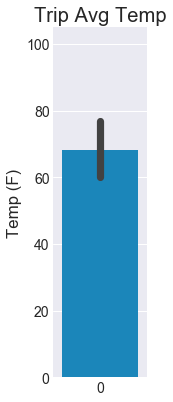

In [29]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(1.5,6))
plt.ylabel("Temp (F)")
plt.ylim(0,105)
plt.title("Trip Avg Temp")
sns.barplot(ax=ax, data=temp)
plt.show()